# Using a Pretrained VGG16 to classify retinal damage from OCT Scans

## Motivation and Context

[Transfer learning](https://en.wikipedia.org/wiki/Transfer_learning) turns out to be useful when dealing with relatively small datasets; for examples medical images, which are harder to obtain in large numbers than other datasets. 
Instead of training a deep neural network from scratch, which would require a significant amount of data, power and time, it's often convenient to use a pretrained model and just finetune its performance to simplify and speed up the process.

*If you are new to convolutional neural networks (CNNs) be sure to check out the [wikipedia page on CNNs](https://en.wikipedia.org/wiki/Convolutional_neural_network) for a more detailed description*

In short, convolutional networks are used on (but not only)  images instead of fully-connected feedforward networks because they would require a very high number of neurons - i.e. at least one per pixel in the input layer - and that would make them inconvenient.

CNNs solve this problem by using a different architecture, summarized in Figure 1

![**Figure 1:** CNN architecture](https://it.mathworks.com/content/mathworks/it/it/discovery/convolutional-neural-network/_jcr_content/mainParsys/image_copy.adapt.full.high.jpg/1523891801700.jpg)

**Figure 1:** CNN architecture (from https://it.mathworks.com/discovery/convolutional-neural-network.html) 

We can identify two main blocks inside of a typical CNN: 
 - Feature extraction
 - Classification
 
The feature extraction is made of a series of convolutional and pooling layers which extract features from the image, increasing in complexity in each layer (i.e. from simpler features in the first layers as points, to more complex ones in the last layers like edges and shapes; see more at [Link #1](http://cs231n.github.io/understanding-cnn) and [Link #2](https://github.com/utkuozbulak/pytorch-cnn-visualizations)).

These features are then fed to a fully connected network (classifier), which learns to classify them.

*Read more about CNNs at http://cs231n.github.io/convolutional-networks/*

So, what we'll do here is using a model (VGG-16)  which is already capable of extracting features from an image and train its fully connected network in order to classify different types of retinal damage instead of objects.

The model we'll use is a [VGG-16](https://www.quora.com/What-is-the-VGG-neural-network)- convolutional network, trained on [ImageNet](http://www.image-net.org/) dataset. 

This work will use [PyTorch](https://pytorch.org/) as deep learning framework and [CUDA](https://developer.nvidia.com/cuda-zone) for GPU acceleration. 

## About Retinal OCT

*Quoted from https://www.kaggle.com/paultimothymooney/kermany2018 *

Retinal optical coherence tomography (OCT) is an imaging technique used to capture high-resolution cross sections of the retinas of living patients. Approximately 30 million OCT scans are performed each year, and the analysis and interpretation of these images takes up a significant amount of time (Swanson and Fujimoto, 2017).

![Figure 2](https://i.imgur.com/fSTeZMd.png)

Figure 2. Representative Optical Coherence Tomography Images and the Workflow Diagram [Kermany et. al. 2018] http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5

(A) (Far left) choroidal neovascularization (CNV) with neovascular membrane (white arrowheads) and associated subretinal fluid (arrows). (Middle left) Diabetic macular edema (DME) with retinal-thickening-associated intraretinal fluid (arrows). (Middle right) Multiple drusen (arrowheads) present in early AMD. (Far right) Normal retina with preserved foveal contour and absence of any retinal fluid/edema.

## Implementation

In [1]:
from __future__ import print_function, division
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from glob import glob
import shutil
from sklearn.model_selection import train_test_split
from PIL import Image
plt.ion()  

use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")

Using CUDA


In [2]:
fn_list = [fn for fn in glob(os.path.join('/kaggle/input/plant-seedings/train/', '**/*.png'), recursive=True)]
print(len(fn_list))

labels = [f.split(os.sep)[-1] for f in glob(os.path.join('/kaggle/input/plant-seedings/train', '**')) if not f.endswith('.txt')]
print(labels)

4750
['Scentless Mayweed', 'Common wheat', 'Charlock', 'Black-grass', 'Sugar beet', 'Loose Silky-bent', 'Maize', 'Cleavers', 'Common Chickweed', 'Fat Hen', 'Small-flowered Cranesbill', 'Shepherds Purse']


In [3]:
def create_foder_dataset():
    # Define the root folder where your dataset is located
    root_folder = '/kaggle/input/plant-seedings/train'

    # Define the 10 classes
    classes = labels

    # Define the folders for training, validation, and test sets
    train_folder = '/kaggle/working/dataset/train'
    valid_folder = '/kaggle/working/dataset/valid'
    test_folder = '/kaggle/working/dataset/test'

    # Create the train, valid, and test folders if they don't exist
    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(valid_folder, exist_ok=True)
    os.makedirs(test_folder, exist_ok=True)

    # Split the dataset into train, valid, and test sets for each class
    for class_name in classes:
        class_folder = os.path.join(root_folder, class_name)
        images = os.listdir(class_folder)
        train_images, test_images = train_test_split(images, test_size=0.1, random_state=42)
        train_images, valid_images = train_test_split(train_images, test_size=0.1, random_state=42)

        os.makedirs(os.path.join(train_folder,class_name))
        os.makedirs(os.path.join(valid_folder,class_name))
        os.makedirs(os.path.join(test_folder,class_name))
        # Move images to the respective folders
        for image in train_images:
            src_path = os.path.join(class_folder, image)
            dest_path = os.path.join(train_folder,class_name, image)
            shutil.copy(src_path, dest_path)

        for image in valid_images:
            src_path = os.path.join(class_folder, image)
            dest_path = os.path.join(valid_folder, class_name, image)
            shutil.copy(src_path, dest_path)

        for image in test_images:
            src_path = os.path.join(class_folder, image)
            dest_path = os.path.join(test_folder, class_name, image)
            shutil.copy(src_path, dest_path)


In [4]:
create_folder = True
if create_folder:
    create_foder_dataset()

*Python Modules*

## Dataset loader

The dataset is divided in three categories: training, validation and test. 

The first one will be, obviously, used for trainig; the validation set will be used to measure the model performance during training and the test set will be used to evaluate our model performance once the training has finished.

*Note:* These three sets should all contain different images.

Loading this dataset with pytorch is really easy using [ImageFolder](https://pytorch.org/docs/master/torchvision/datasets.html#imagefolder) as the labels are specified by the folders names.  

In [5]:
# data_dir = '../input/kermany2018/oct2017/OCT2017 '
# TRAIN = 'train'
# VAL = 'val'
# TEST = 'test'
data_dir = '/kaggle/working/dataset/'
TRAIN = 'train'
VAL = 'valid'
TEST = 'test'
# VGG-16 Takes 224x224 images as input, so we resize all of them
data_transforms = {
    TRAIN: transforms.Compose([
        # Data augmentation is a good practice for the train set
        # Here, we randomly crop the image to 224x224 and
        # randomly flip it horizontally. 
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    VAL: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]),
    TEST: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ])
}
image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(data_dir, x), 
        transform=data_transforms[x]
    )
    for x in [TRAIN, VAL, TEST]
}

dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=8,
        shuffle=True, num_workers=4
    )
    for x in [TRAIN, VAL, TEST]
}

dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, VAL, TEST]}

for x in [TRAIN, VAL, TEST]:
    print("Loaded {} images under {}".format(dataset_sizes[x], x))
    
print("Classes: ")
class_names = image_datasets[TRAIN].classes
print(image_datasets[TRAIN].classes)

Loaded 3837 images under train
Loaded 431 images under valid
Loaded 482 images under test
Classes: 
['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']


In [6]:
class MyTestDataset(torch.utils.data.Dataset):
  def __init__(self, path):
    self.fn_list = [fn for fn in glob(os.path.join(path, '**/*.png'), recursive=True)]
    self.labels = [f.split(os.sep)[-1] for f in glob(os.path.join(path, '**')) if not f.endswith('.txt')]
    self.transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ])

  def __getitem__(self, i):
    x = Image.open(self.fn_list[i]).convert('RGB')
    x = self.transform(x)
    text = test_dataset.fn_list[i]
    file = text.split(os.sep)[-1]
    return x, file
  
  def __len__(self):
    return len(self.fn_list)

In [7]:
test_dataset = MyTestDataset('/kaggle/input/plant-seedings/test')
print(test_dataset.labels[:5])
print(len(test_dataset))

send_test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=8,
        shuffle=True, num_workers=4
    )
print('Len :', len(send_test_loader))

['fd87b36ae.png', '0e8492cb1.png', '8d6acbe9b.png', '54b3afd58.png', '6049234e6.png']
794
Len : 100


## Utils

Some utility function to visualize the dataset and the model's predictions

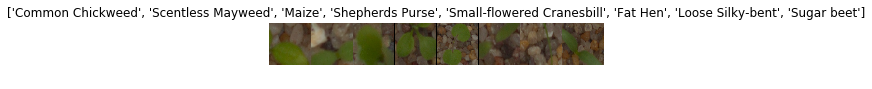

In [8]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    # plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(dataloaders[TRAIN]))
show_databatch(inputs, classes)

In [9]:
def visualize_model(vgg, num_images=6):
    was_training = vgg.training
    
    # Set model for evaluation
    vgg.train(False)
    vgg.eval() 
    
    images_so_far = 0

    for i, data in enumerate(dataloaders[TEST]):
        inputs, labels = data
        size = inputs.size()[0]
        
        if use_gpu:
            inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
        else:
            inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)
        
        outputs = vgg(inputs)
        
        _, preds = torch.max(outputs.data, 1)
        predicted_labels = [preds[j] for j in range(inputs.size()[0])]
        
        print("Ground truth:")
        show_databatch(inputs.data.cpu(), labels.data.cpu())
        print("Prediction:")
        show_databatch(inputs.data.cpu(), predicted_labels)
        
        del inputs, labels, outputs, preds, predicted_labels
        torch.cuda.empty_cache()
        
        images_so_far += size
        if images_so_far >= num_images:
            break
        
    vgg.train(mode=was_training) # Revert model back to original training state

This helper function will give us the accuracy of our model on the test set.

In [10]:
def eval_model(vgg, criterion):
    since = time.time()
    avg_loss = 0
    avg_acc = 0
    loss_test = 0
    acc_test = 0
    
    test_batches = len(dataloaders[TEST])
    print("Evaluating model")
    print('-' * 10)
    
    for i, data in enumerate(dataloaders[TEST]):
        if i % 100 == 0:
            print("\rTest batch {}/{}".format(i, test_batches), end='', flush=True)

        vgg.train(False)
        vgg.eval()
        inputs, labels = data

        if use_gpu:
            inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
        else:
            inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)

        outputs = vgg(inputs)

        _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)

        loss_test += loss.data[0]
        acc_test += torch.sum(preds == labels.data)

        del inputs, labels, outputs, preds
        torch.cuda.empty_cache()
        
    avg_loss = loss_test / dataset_sizes[TEST]
    avg_acc = acc_test / dataset_sizes[TEST]
    
    elapsed_time = time.time() - since
    print()
    print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Avg loss (test): {:.4f}".format(avg_loss))
    print("Avg acc (test): {:.4f}".format(avg_acc))
    print('-' * 10)

## Model creation

The [VGG-16](https://www.quora.com/What-is-the-VGG-neural-network) is able to classify 1000 different labels; we just need 4 instead. 
In order to do that we are going replace the last fully connected layer of the model with a new one with 4 output features instead of 1000. 

In PyTorch, we can access the VGG-16 classifier with `model.classifier`, which is an 6-layer array. We will replace the last entry.

We can also disable training for the convolutional layers setting `requre_grad = False`, as we will only train the fully connected classifier.

In [11]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16_bn()
vgg16.load_state_dict(torch.load("../input/vgg16bn/vgg16_bn.pth"))
print(vgg16.classifier[6].out_features) # 1000 


# Freeze training for all layers
for param in vgg16.features.parameters():
    param.require_grad = False

# Newly created modules have require_grad=True by default
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, len(class_names))]) # Add our layer with 4 outputs
vgg16.classifier = nn.Sequential(*features) # Replace the model classifier
print(vgg16)

1000
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine

The output above is the summary of our model. Notice how the last layer has 4 output features as we specified. 

In [12]:
# If you want to train the model for more than 2 epochs, set this to True after the first run
resume_training = True

if resume_training:
    print("Loading pretrained model..")
    vgg16.load_state_dict(torch.load('/kaggle/input/vgg16-plant-seedings-dict-model/VGG16_v2-plant-dict-seedings.pt'))
    print("Loaded!")

Loading pretrained model..
Loaded!


We will also define our loss function (cross entropy) and the optimizer. 

The learning rate will start at 0.001 and a StepLR object will decrese it by a factor of 0.1 every 7 epochs (not really needed here as we're training for 2 epochs only)

For further details refer to https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html


In [13]:
print('start')
if use_gpu:
    if torch.cuda.device_count() > 1 :
        print('use multiple gpu')
        vgg16 = nn.DataParallel(vgg16)
    vgg16.cuda() #.cuda() will move everything to the GPU side
    print('use gpu')
    
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

start
use gpu


## Model evaluation and visualization (before training)

Let's see how our model performs before any training

In [14]:
print("Test before training")
eval_model(vgg16, criterion)

Test before training
Evaluating model
----------
Test batch 0/61
Evaluation completed in 0m 10s
Avg loss (test): 0.0118
Avg acc (test): 0.9813
----------


Ground truth:


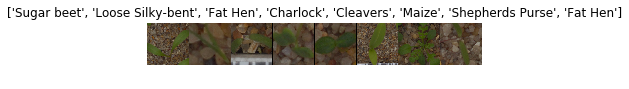

Prediction:


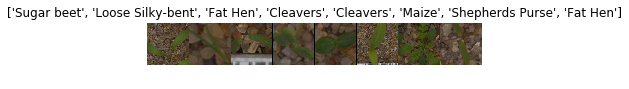

In [15]:
visualize_model(vgg16) #test before training

Not really great results. Let's see if it can do better after training 

## Training

What follows is [pretty standard pytorch code for training](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html). 

For every epoch we iterate over all the training batches, compute the loss , and adjust the network weights with `loss.backward()` and `optimizer.step()`. 
Then we evaluate the performance over the validaton set. At the end of every epoch we print the network progress (loss and accuracy). 
The accuracy will tell us how many predictions were correct.

As we said before, transfer learning can work on smaller dataset too, so for every epoch we only iterate over half the trainig dataset (worth noting that it won't exactly be half of it over the entire training, as the data is shuffled, but it will almost certainly be a subset) 

In [16]:
def train_model(vgg, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(vgg.state_dict())
    best_acc = 0.0
    
    avg_loss = 0
    avg_acc = 0
    avg_loss_val = 0
    avg_acc_val = 0
    
    train_batches = len(dataloaders[TRAIN])
    val_batches = len(dataloaders[VAL])
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs))
        print('-' * 10)
        
        loss_train = 0
        loss_val = 0
        acc_train = 0
        acc_val = 0
        
        vgg.train(True)
        
        for i, data in enumerate(dataloaders[TRAIN]):
            if i % 100 == 0:
                print("\rTraining batch {}/{}".format(i, train_batches / 2), end='', flush=True)
                
            # Use half training dataset
            if i >= train_batches / 2:
                break
                
            inputs, labels = data
            
            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)
            
            optimizer.zero_grad()
            
            outputs = vgg(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            loss_train += loss.data[0]
            acc_train += torch.sum(preds == labels.data)
            
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        print()
        # * 2 as we only used half of the dataset
        avg_loss = loss_train * 2 / dataset_sizes[TRAIN]
        avg_acc = acc_train * 2 / dataset_sizes[TRAIN]
        
        vgg.train(False)
        vgg.eval()
            
        for i, data in enumerate(dataloaders[VAL]):
            if i % 100 == 0:
                print("\rValidation batch {}/{}".format(i, val_batches), end='', flush=True)
                
            inputs, labels = data
            
            if use_gpu:
                inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
            else:
                inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)
            
            optimizer.zero_grad()
            
            outputs = vgg(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            loss_val += loss.data[0]
            acc_val += torch.sum(preds == labels.data)
            
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        avg_loss_val = loss_val / dataset_sizes[VAL]
        avg_acc_val = acc_val / dataset_sizes[VAL]
        
        print()
        print("Epoch {} result: ".format(epoch))
        print("Avg loss (train): {:.4f}".format(avg_loss))
        print("Avg acc (train): {:.4f}".format(avg_acc))
        print("Avg loss (val): {:.4f}".format(avg_loss_val))
        print("Avg acc (val): {:.4f}".format(avg_acc_val))
        print('-' * 10)
        print()
        
        if avg_acc_val > best_acc:
            best_acc = avg_acc_val
            best_model_wts = copy.deepcopy(vgg.state_dict())
        
    elapsed_time = time.time() - since
    print()
    print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Best acc: {:.4f}".format(best_acc))
    
    vgg.load_state_dict(best_model_wts)
    return vgg

In [17]:
vgg16 = train_model(vgg16, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=60)
torch.save(vgg16.state_dict(), 'VGG16_v2-plant-dict-seedings.pt')

Epoch 0/60
----------
Training batch 200/240.0
Validation batch 0/54
Epoch 0 result: 
Avg loss (train): 0.0146
Avg acc (train): 0.9601
Avg loss (val): 0.0223
Avg acc (val): 0.9652
----------

Epoch 1/60
----------
Training batch 200/240.0
Validation batch 0/54
Epoch 1 result: 
Avg loss (train): 0.0148
Avg acc (train): 0.9617
Avg loss (val): 0.0206
Avg acc (val): 0.9536
----------

Epoch 2/60
----------
Training batch 200/240.0
Validation batch 0/54
Epoch 2 result: 
Avg loss (train): 0.0132
Avg acc (train): 0.9638
Avg loss (val): 0.0197
Avg acc (val): 0.9722
----------

Epoch 3/60
----------
Training batch 200/240.0
Validation batch 0/54
Epoch 3 result: 
Avg loss (train): 0.0189
Avg acc (train): 0.9544
Avg loss (val): 0.0214
Avg acc (val): 0.9652
----------

Epoch 4/60
----------
Training batch 200/240.0
Validation batch 0/54
Epoch 4 result: 
Avg loss (train): 0.0131
Avg acc (train): 0.9627
Avg loss (val): 0.0258
Avg acc (val): 0.9582
----------

Epoch 5/60
----------
Training batch 200

## Model evaluation and visualization (after training)

Let's evaluate our model again after 2 epochs of training

In [18]:
eval_model(vgg16, criterion)

Evaluating model
----------
Test batch 0/61
Evaluation completed in 0m 7s
Avg loss (test): 0.0175
Avg acc (test): 0.9668
----------


Now that's a pretty good result!

Ground truth:


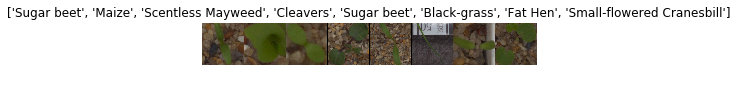

Prediction:


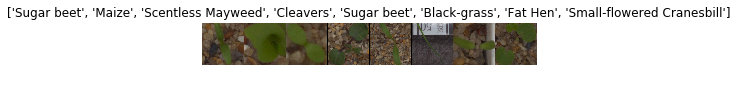

Ground truth:


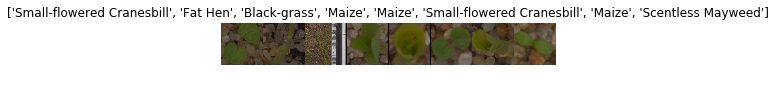

Prediction:


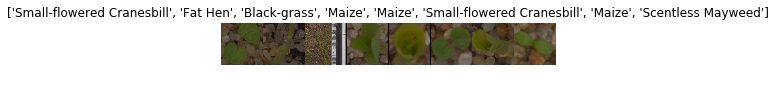

In [19]:
visualize_model(vgg16, num_images=16)

## Things to try
- Reduce the training dataset even further, and increase the test set
- Implement other evaluation metrics like in https://www.kaggle.com/paultimothymooney/detect-retina-damage-from-oct-images/notebook

Hope you found this useful! 

In [20]:
def get_data_send_model(vgg, class_names):
    was_training = vgg.training
    
    # Set model for evaluation
    vgg.train(False)
    vgg.eval() 
    labels = []
    all_files = []
    images_so_far = 0

    for i, data in enumerate(send_test_loader):
        inputs ,files = data
        size = inputs.size()[0]
        
        if use_gpu:
            inputs = Variable(inputs.cuda(), volatile=True)
        else:
            inputs = Variable(inputs, volatile=True)
        
        outputs = vgg(inputs)
        
        _, preds = torch.max(outputs.data, 1)
        predicted_labels = [preds[j] for j in range(inputs.size()[0])]
        [labels.append(class_names[label]) for label in predicted_labels ]
        [all_files.append(file) for file in files]
        
        del inputs, outputs, preds, predicted_labels
        torch.cuda.empty_cache()
        
        
    vgg.train(mode=was_training) # Revert model back to original training state
    return labels, all_files

In [21]:
labels, files = get_data_send_model(vgg16, class_names)

print(len(files))
print(len(labels))

794
794


In [22]:
xtest, ytest = np.array(files), np.array(labels)
print(xtest.shape, ytest.shape)
data = np.column_stack((xtest, ytest))
df = pd.DataFrame(data=data, columns=['file', 'species'])
print(df.head(5))
df.to_csv('datatest60plus.csv', encoding='utf-8', index=False)

(794,) (794,)
            file            species
0  af45e222a.png  Scentless Mayweed
1  fdea6b119.png        Black-grass
2  90b595f12.png   Common Chickweed
3  1cfd91582.png           Charlock
4  23e480e64.png    Shepherds Purse
